In [308]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

#Read The Data

In [266]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [267]:
train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [268]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [269]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


#Plot The Data

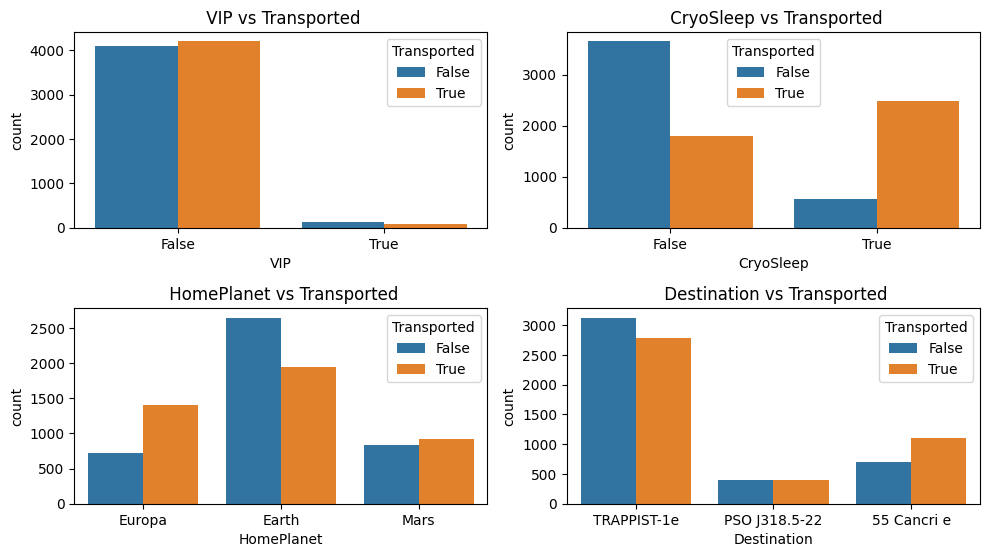

In [270]:

plt.figure(figsize=(10, 8))

plt.subplot(3, 2, 1)
sns.countplot(data=train, x='VIP', hue='Transported')
plt.title(" VIP vs Transported")

plt.subplot(3, 2, 2)
sns.countplot(data=train, x='CryoSleep', hue='Transported')
plt.title(" CryoSleep vs Transported")

plt.subplot(3, 2, 3)
sns.countplot(data=train, x='HomePlanet', hue='Transported')
plt.title(" HomePlanet vs Transported")

plt.subplot(3, 2, 4)
sns.countplot(data=train, x='Destination', hue='Transported')
plt.title(" Destination vs Transported")


plt.tight_layout()
plt.show()

In [271]:
train['Destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [272]:
train['Destination'].isna().sum()

182

In [273]:
train['HomePlanet'].unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

In [274]:
train['HomePlanet'].isna().sum()

201

In [275]:
train['CryoSleep'].isna().sum()

217

In [276]:
len(train['Cabin'].unique())

6561

In [277]:
train['Cabin'].isna().sum()

199

In [278]:
train["Transported"].unique()

array([False,  True])

In [279]:
train["Transported"].isna().sum()

0

# Dealing with missed values

In [280]:
train.drop(["Name", "Cabin"], inplace=True, axis=1)
test.drop(["Name", "Cabin"], inplace=True, axis=1)

In [281]:
categorical_columns = train.select_dtypes(include=['object']).columns.drop('PassengerId')
numerical_columns = train.select_dtypes(include=["int32", 'float64']).columns

In [283]:
for col in categorical_columns:
    print(train[col].unique())

['Europa' 'Earth' 'Mars' 'unknown']
['False' 'True' 'unknown']
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' 'unknown']
['False' 'True' 'unknown']


### - Applying lebel encoder on categorical features

In [284]:
le = LabelEncoder()
for col in categorical_columns:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

In [285]:
for col in categorical_columns:
    print(train[col].unique())

[1 0 2 3]
[0 1 2]
[2 1 0 3]
[0 1 2]


### - Apply KNN imputer to fill numerical missed values 

In [286]:
imputer = KNNImputer(n_neighbors=5)

train[numerical_columns] = imputer.fit_transform(train[numerical_columns])
test[numerical_columns] = imputer.transform(test[numerical_columns])

# Spliting the train set to train/val sets to evaluate the models

In [328]:
X = train.drop(['PassengerId', 'Transported'], axis=1)
y = train['Transported']
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=98)

In [288]:
X_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
2333,0,0,2,28.0,0,0.0,55.0,0.0,656.0,0.0
2589,0,0,2,17.0,0,0.0,1195.0,31.0,0.0,0.0
8302,1,1,0,28.0,0,0.0,0.0,0.0,0.0,0.0
8177,2,0,2,20.0,0,838.0,2.0,289.0,976.0,0.0
500,1,1,0,36.0,0,0.0,0.0,0.0,0.0,0.0


# Finding the best model

In [317]:
models = {
    "XGBoost": XGBClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Light GBM": LGBMClassifier()
}

In [331]:
for name, model in models.items():
    print(f'\n{name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f'\nAccuracy: {accuracy_score(y_val, y_pred):.3f}')
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))


XGBoost

Accuracy: 0.798

Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.78      0.80       881
        True       0.78      0.82      0.80       858

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739


Logistic Regression


C:\Users\mmahd\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy: 0.788

Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.72      0.78       881
        True       0.75      0.86      0.80       858

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739


Random Forest

Accuracy: 0.797

Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.80      0.80       881
        True       0.80      0.79      0.79       858

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739


Extra Trees

Accuracy: 0.783

Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.79      0.79       881
        True       0.78      0.78      0.78       858

    accuracy                   

In [355]:
light_gbm_model = LGBMClassifier()


lgbm_grid_params = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'boosting_type': ['gbdt'],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgbm_grid = GridSearchCV(estimator=light_gbm_model, param_grid=lgbm_grid_params, cv=5, n_jobs=-1, verbose=2)
lgbm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [-1, 10, 20],
                         'n_estimators': [100, 300, 500],
                         'num_leaves': [31, 50, 70],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=2)

In [361]:
best_model = lgbm_grid.best_estimator_

In [353]:
import joblib  
joblib.dump(best_model, "best_model_lgbm.pkl")

['best_model_lgbm.pkl']

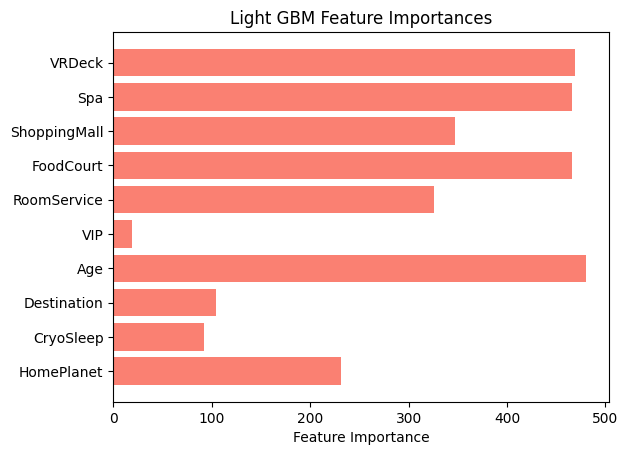

In [360]:
feature_importancity = best_model.feature_importances_
features = X_train.columns

plt.barh(features, feature_importancity, color="salmon")
plt.xlabel("Feature Importance")
plt.title("Light GBM Feature Importances")
plt.show()

In [362]:
y_pred = best_model.predict(X_val)

print(f"Best Light GBM model's accuracy: {accuracy_score(y_val, y_pred):.3f}")
print("\nClassification Report:")
print(f"\n{classification_report(y_val, y_pred)}")

Best Light GBM model's accuracy: 0.807

Classification Report:

              precision    recall  f1-score   support

       False       0.84      0.77      0.80       881
        True       0.78      0.85      0.81       858

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



# Training final model with the whole dataset.

In [365]:
best_params = lgbm_grid.best_params_

final_model = LGBMClassifier(**best_params)

In [366]:
final_model.fit(X,y)

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, subsample=0.6)

In [367]:
joblib.dump(final_model, "final_model_lgbm.pkl")

['final_model_lgbm.pkl']

In [371]:
X_test_submission = test.drop("PassengerId", axis=1)

In [372]:
y_pred_submission =  final_model.predict(X_test_submission)

In [373]:
submission = pd.DataFrame({"PassengerId": test['PassengerId'], "Transported": y_pred_submission})

In [375]:
submission.to_csv("submission.csv", index=False)